In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Bulle T4cGCaMP data

In [2]:
Bulle_T4cGcamp_grating_data = pd.read_csv("data/Bulle/GCaMP_Grating_TimeSeries.txt",sep="\t")
column = ['time']
velocity = [15, 30, 60, 120]
[column.extend(['Mean_PD_'+str(velocity[i]),'SEM_PD_'+str(velocity[i])]) for i in range(len(velocity))];
[column.extend(['Mean_ND_'+str(velocity[i]),'SEM_ND_'+str(velocity[i])]) for i in range(len(velocity))];
Bulle_T4cGcamp_grating_data.columns = column
#Bulle_T4cGcamp_grating_data

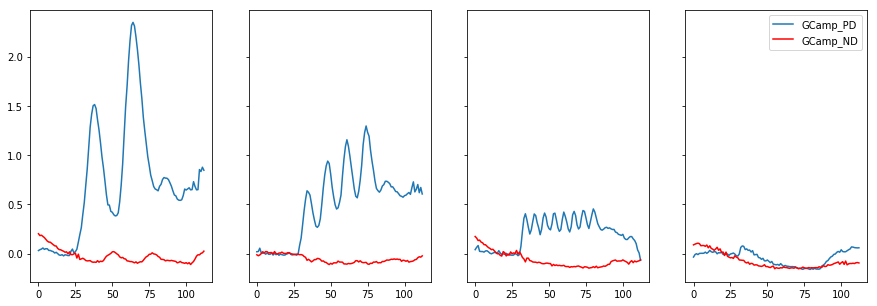

In [3]:
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_T4cGcamp_grating_data['Mean_PD_'+str(velocity[i])], label='GCamp_PD') for i in range(4)];
[ax[i].plot(Bulle_T4cGcamp_grating_data['Mean_ND_'+str(velocity[i])], color='red', label='GCamp_ND') for i in range(4)];
plt.legend();
plt.savefig('figures/Bulle_T4cGrating_Gcamp.pdf', dpi = 1000)

### Bulle ArcLight data

In [4]:
Bulle_arclight_grating_data = pd.read_csv("data/Bulle/ArcLight_Grating_TimeSeries.txt",sep="\t")
column = ['time']
velocity = [15, 30, 60, 120]
[column.extend(['Mean_PD_'+str(velocity[i]),'SEM_PD_'+str(velocity[i])]) for i in range(len(velocity))];
[column.extend(['Mean_ND_'+str(velocity[i]),'SEM_ND_'+str(velocity[i])]) for i in range(len(velocity))];
Bulle_arclight_grating_data.columns = column
#Bulle_arclight_grating_data

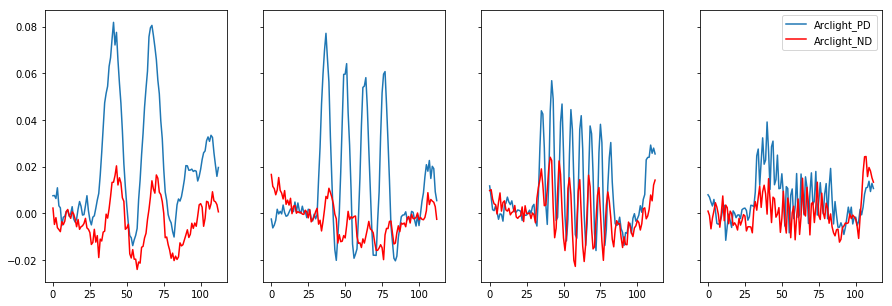

In [5]:
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_arclight_grating_data['Mean_PD_'+str(velocity[i])], label='Arclight_PD') for i in range(4)];
[ax[i].plot(Bulle_arclight_grating_data['Mean_ND_'+str(velocity[i])], color='red', label='Arclight_ND') for i in range(4)];
plt.legend();

#### Model (threshold, lowpass filter, gain)

In [6]:
def lowpass_filter(x, tau=0.550,dt=0.01):
    y = np.zeros(len(x))
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,len(y)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
        
    return y

In [7]:
def threshold_cut(x, thres=0):
    x[x<thres] = 0
    return x
    

In [8]:
def Ca_model(x, tau=0.550, dt=0.0769, thres=0.0, gain=1.0):
    x_thres = threshold_cut(x, thres)
    x_thres_lowpass = lowpass_filter(x_thres, tau, dt)
    x_thres_lowpass_gain = gain*x_thres_lowpass
    
    return x_thres_lowpass_gain

In [9]:
def error_calc(x, y):
    err = (np.nanmax(x) - np.nanmax(y))**2
    return err

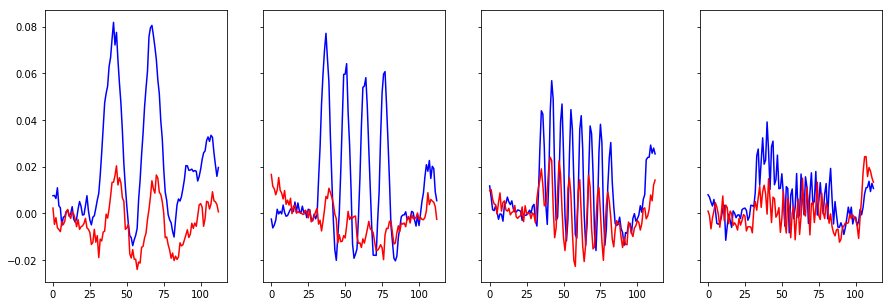

In [10]:
velocity = [15, 30, 60, 120]
df_arclight = Bulle_arclight_grating_data.copy()
thres = 0.0; tau = 0.3; gain = 120; dt = df_arclight.iloc[7]['time'] - df_arclight.iloc[6]['time']
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(df_arclight['Mean_PD_'+str(velocity[i])],'b') for i in range(4)];
[ax[i].plot(df_arclight['Mean_ND_'+str(velocity[i])], 'r') for i in range(4)];

In [11]:
#velocities used for error calculation
velocity = [15, 30, 60]; stim=[]
#[stim.extend(['Mean_PD_'+str(velocity[i]),'Mean_ND_'+str(velocity[i])]) for i in range(len(velocity))];
[stim.extend(['Mean_PD_'+str(velocity[i])]) for i in range(len(velocity))];
velocity = [15]
[stim.extend(['Mean_ND_'+str(velocity[i])]) for i in range(len(velocity))];
print (stim)

['Mean_PD_15', 'Mean_PD_30', 'Mean_PD_60', 'Mean_ND_15']


In [12]:
thres = np.linspace(-0.04, 0.04, 10)
tau =np.linspace(0.5,2.5,10)
gain = np.linspace(30.0, 110.0, 10)
error = np.zeros((len(thres), len(tau), len(gain)))
for i in range(len(thres)):
    for j in range(len(tau)):
        for k in range(len(gain)):
            err_= 0
            for sti in stim:
                PD_Gcamp_data = np.array(Bulle_T4cGcamp_grating_data[sti])
                PD_arclight = np.array(df_arclight[sti])
                model_data = Ca_model(PD_arclight.copy(), tau[j], dt, thres[i], gain[k])
                err_ += error_calc(PD_Gcamp_data.copy(), model_data.copy())
            error[i, j, k] = err_/len(stim)
error.min()

0.01653386956114183

In [13]:
thres_model = thres[np.argwhere(error == np.min(error))[0][0]]
tau_model = tau[np.argwhere(error == np.min(error))[0][1]]
gain_model = gain[np.argwhere(error == np.min(error))[0][2]]
thres_model, tau_model, gain_model 

(0.04, 2.0555555555555554, 74.44444444444444)

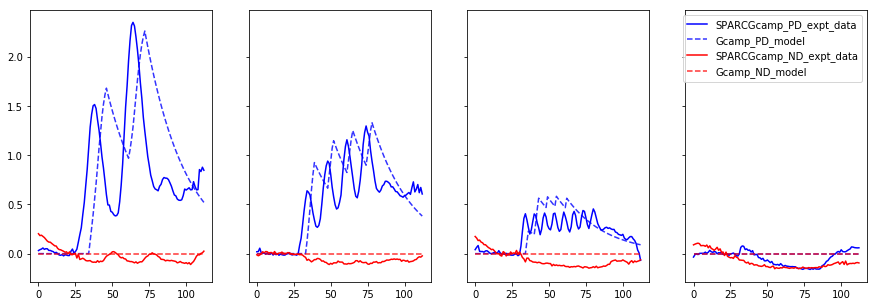

In [14]:
velocity = [15, 30, 60, 120]
f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_T4cGcamp_grating_data['Mean_PD_'+str(velocity[i])],'b',
            label='SPARCGcamp_PD_expt_data') for i in range(4)];
[ax[i].plot(Ca_model(df_arclight['Mean_PD_'+str(velocity[i])].copy(),
                    tau_model, dt, thres_model, gain_model), 'b--', label='Gcamp_PD_model', alpha=0.8) for i in range(4)];

[ax[i].plot(Bulle_T4cGcamp_grating_data['Mean_ND_'+str(velocity[i])],'r',
            label='SPARCGcamp_ND_expt_data') for i in range(4)];
[ax[i].plot(Ca_model(df_arclight['Mean_ND_'+str(velocity[i])].copy(),
                     tau_model, dt, thres_model, gain_model), 'r--', label='Gcamp_ND_model', alpha=0.8) for i in range(4)];
plt.legend();
plt.savefig('figures/T4cGrating_Model.pdf', dpi = 1000)